<a href="https://colab.research.google.com/github/ammarSherif/CIT690E-Deep-Learning-Labs/blob/main/Lab%203%3A%20Building%20Neural%20Networks%20with%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Building Neural Networks with Pytorch

CIT690E: Deep Learning <br>
Nile University<br>
Ammar Sherif<br>
Github Repo: [CIT690E-Deep-Learning-Labs](https://github.com/ammarSherif/CIT690E-Deep-Learning-Labs)

## Outline

In this lab, we will learn how to build our first Neural Network using Pytorch. Below is the outline

In [ ]:
# ==============================================================================
# Some imports that we are using in our lab
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ==============================================================================
# Identify the device at the beginning
# ==============================================================================
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Dataset

We will use **MNIST dataset**. It contains group of hand written digits. Our objective is to build a model that is able to identify the hand-written digit in an image. Below are some details:


*   60K training samples
*   10K testing samples
*   10 output classes [0-9], **classification**
*   Input image size: 28x28

### Loading Dataset

In [ ]:
# ==============================================================================
# Load the data and transform it
# ==============================================================================
train_data = MNIST(root='./data',train=True,download=True,transform=ToTensor())
val_data = MNIST(root='./data',train=False,download=True,transform=ToTensor())

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4,
                          pin_memory=True)
val_loader = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Samples

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


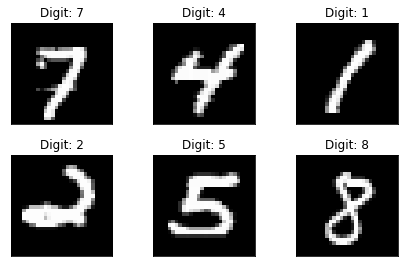

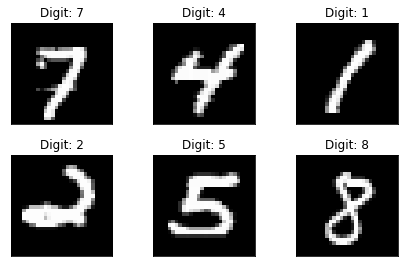

In [ ]:
# ==============================================================================
# Showing some examples
# ==============================================================================
example_data, example_targets = next(iter(train_loader))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

fig

## Feed Forward Neural Network

The idea is that we will be building a normal Feed Forward Neural network and train it to classify the digits correctly. Therefore, because we are having images as input, we are **flattening** the inputs as first, converting the image from 2D to 1D to be entered to neurons; after that we use this as input to our feed forward neural network.

In [ ]:
# ==============================================================================
# Building a generic model
# ==============================================================================
class FFNN(nn.Module):
    """Simple Feed Forward Neural Network with variable hidden layers
    
    Inputs:
    - input_size: the input size after flattening the image
    - num_hidden_layers: the number of hidden layers
    - hidden_size: the size of the hidden layers
    - out_size: the number of clusters [0-9]
    - accuracy_function: the accuracy based on which we evaluate the results
    """
    def __init__(self, input_size, num_hidden_layers, hidden_size, out_size,
                 accuracy_function):
        super().__init__()
        self.flatten_layer = nn.Flatten()
        self.accuracy_function = accuracy_function
        
        # Create first hidden layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Create remaining hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(0, num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Create output layer
        self.output_layer = nn.Linear(hidden_size, out_size)

    # --------------------------------------------------------------------------
    
    def forward(self, input_image):
        
        # Flatten image
        input_image = self.flatten_layer(input_image)
        
        # Utilize hidden layers and apply activation function
        output = self.input_layer(input_image)
        output = F.relu(output)
        
        for layer in self.hidden_layers:
            output = layer(output)
            output = F.relu(output)
        
        # Get predictions
        output = self.output_layer(output)
        return output
    
    # --------------------------------------------------------------------------

    def training_step(self, batch):
        # Load batch
        images, labels = batch

        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    # --------------------------------------------------------------------------

    def validation_step(self, batch):
        # Load batch
        images, labels = batch

        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
        
    # --------------------------------------------------------------------------

    def validation_epoch_end(self, outputs):
        
        # Combine losses and return mean value
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # --------------------------------------------------------------------------

    def epoch_end(self, epoch, result):
        print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}\
        ".format(epoch+1, result['val_loss'], result['val_acc']))

Briefly, we are having the below methods:

- `forward`: **overriden** performs the forward pass producing the model output
- `training_step`: performs one step during the training
- `validation_step`: performs one step of the validation process
- `validation_epoch_end`: computes the validation loss and accuracy per epoch
- `epoch_end`: merely printing function done at the end of each epoch

### Training

In [ ]:
class ModelTrainer():
  """The class automatically train our model
  """
  def fit(self, epochs, learning_rate, model, train_loader, val_loader, 
          opt_func=torch.optim.SGD):
    """The function trains a model according to the hyperparameters:
    - epochs: the total number of epochs of training
    - learning_rate: the learning rate of our optimizer
    - model: the model to be trained
    - train_loader: the loader holding the training data
    - val_loader: the loader holding the validation data
    """
    history = []
    optimizer = opt_func(model.parameters(), learning_rate)

    for epoch in range(epochs):
        # Training 
        model.train()
        for batch in train_loader:
            # Clear the parameter gradients
            optimizer.zero_grad()
            # perform the forward pass and compute the loss
            loss = model.training_step(batch)
            # perform the backward pass
            loss.backward()
            optimizer.step()
            

        # Validation
        model.eval()
        result = self._evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

  def _evaluate(self, model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def plot_history(history):
  losses = [x['val_loss'] for x in history]
  accuracies = [x['val_acc'] for x in history]
  _,ax = plt.subplots()
  ax.plot(losses, '-x')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_title('Loss Curve on Validation')

  _,ax = plt.subplots()
  ax.plot(accuracies, '-x')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_title('Accuracy Curve on Validation')

### Performing the results

In [ ]:
# ==============================================================================
# Have some specs as below:
# - input_size = 28*28 = 784
# ==============================================================================
input_size = 784
num_classes = 10
num_hidden_layers = 3
hidden_layer_size = 32
model = FFNN(input_size, num_hidden_layers, hidden_layer_size,
             out_size=num_classes, accuracy_function=accuracy).to(device)
print(model)

FFNN(
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (input_layer): Linear(in_features=784, out_features=32, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
model_trainer = ModelTrainer()

training_history = []
training_history = model_trainer.fit(5, 0.2, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 - Validation Loss: 0.4081, Validation Accuracy: 0.8767        
Epoch: 2 - Validation Loss: 0.2058, Validation Accuracy: 0.9410        
Epoch: 3 - Validation Loss: 0.1757, Validation Accuracy: 0.9484        
Epoch: 4 - Validation Loss: 0.1329, Validation Accuracy: 0.9597        
Epoch: 5 - Validation Loss: 0.1414, Validation Accuracy: 0.9568        


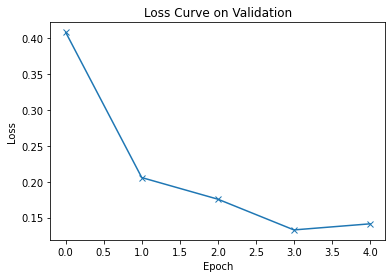

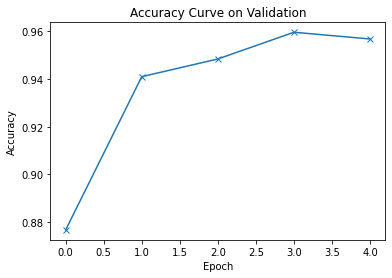

In [ ]:
plot_history(training_history)

## Convolutional Neural Network

Convolutional layers are considered to perform better on images, so we are building a CNN. Nevertheless, before start building the model, we are clairifying the convolution as if you were training on some **image filters**. Therefore, instead of specifying the filters manually or even using a feedforward, the model will learn to extract some useful features while training. We are creating the below model:

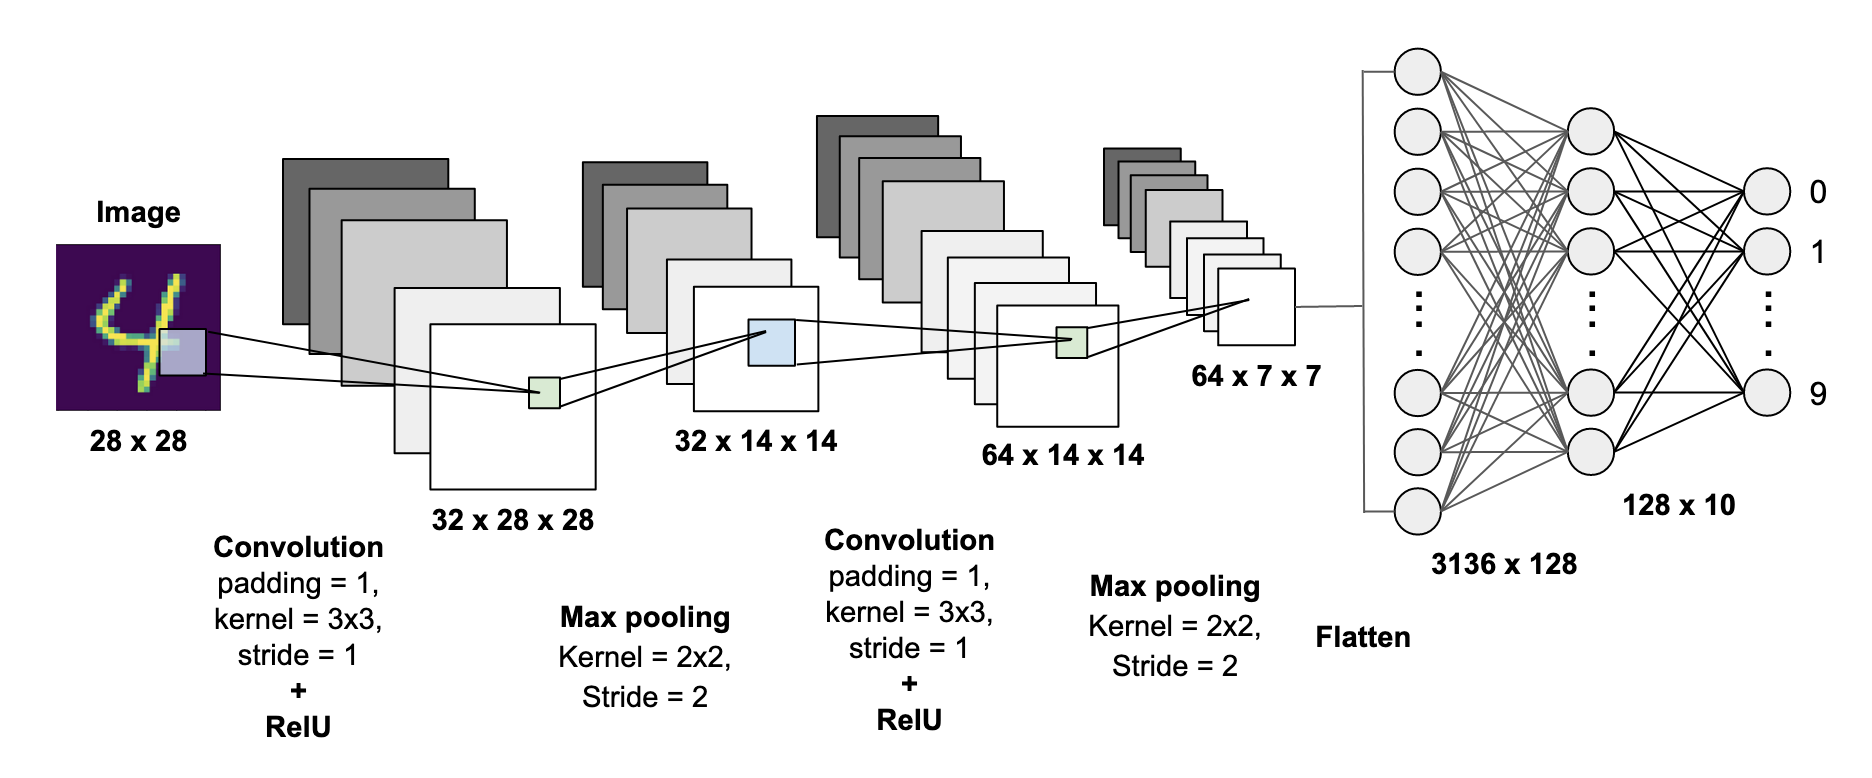

In [ ]:
class CNN(nn.Module):
    """Simple Convolutional Neural Network"""
    def __init__(self, accuracy_function):
        super().__init__()
        self.accuracy_function = accuracy_function

        # Create Convolutional Layers
        self.model = nn.Sequential(
            # Dimension: 28*28
            nn.Conv2d(in_channels=1,out_channels=32, kernel_size=3,
                      stride=1, padding=1),
            # Dimension: 28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            # Dimension: 14*14
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride= 2),
            # Dimension: 7*7
            nn.Flatten(),
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, input_image):
        # Just run the imput into the sequential model
        output = self.model(input_image)
        return output
    
    def training_step(self, batch):
        # Load batch
        images, labels = batch
        
        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    def validation_step(self, batch):
        # Load batch
        images, labels = batch

        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        
        # Combine losses and return mean value
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}\
              ".format(epoch+1, result['val_loss'], result['val_acc']))

### Checking Results

In [ ]:
input_size = 784
num_classes = 10

model = CNN(accuracy_function=accuracy).to(device)
print(model)

CNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
model_trainer = ModelTrainer()

training_history = []
training_history = model_trainer.fit(5, 0.2, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 - Validation Loss: 0.0690, Validation Accuracy: 0.9778              
Epoch: 2 - Validation Loss: 0.0513, Validation Accuracy: 0.9842              
Epoch: 3 - Validation Loss: 0.0348, Validation Accuracy: 0.9883              
Epoch: 4 - Validation Loss: 0.0315, Validation Accuracy: 0.9893              
Epoch: 5 - Validation Loss: 0.0296, Validation Accuracy: 0.9895              


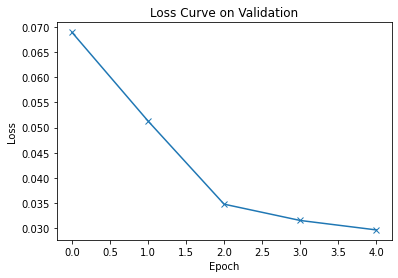

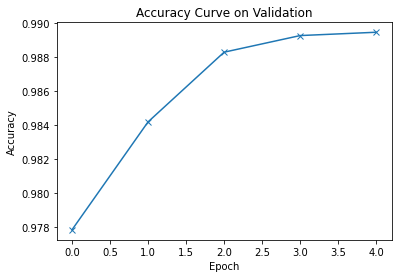

In [ ]:
plot_history(training_history)